In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
metadata = pd.read_csv( "../data/raw/metadata.csv", parse_dates=["scene_start"])
print(metadata.shape)
metadata.shape

(1084, 6)


(1084, 6)

In [3]:
metadata.head()

image_id chip_id flood_id polarization location scene_start
0  awc00_vh   awc00      awc           vh  Bolivia  2018-02-15
1  awc00_vv   awc00      awc           vv  Bolivia  2018-02-15
2  awc01_vh   awc01      awc           vh  Bolivia  2018-02-15
3  awc01_vv   awc01      awc           vv  Bolivia  2018-02-15
4  awc02_vh   awc02      awc           vh  Bolivia  2018-02-15

In [4]:
print(metadata.chip_id.nunique())
print(metadata.groupby("flood_id")["chip_id"].nunique())
metadata.groupby("flood_id")["chip_id"].nunique().describe()

542
flood_id
awc    15
ayt    18
coz    28
hbe    69
hxu    26
jja    66
kuo    65
pxs    68
qus    30
qxb    42
tht    30
tnp    53
wvy    32
Name: chip_id, dtype: int64


count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

In [5]:
import rasterio 

DATA_PATH = '../data/raw/'
EXT = '.tif'

# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):

    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    return matrix.clip(0, 1)

def display_chip(chip_id,metadata):

    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    path = DATA_PATH + '/train_features/' + chip_id + '_vv' + EXT
    with rasterio.open(path) as img:
        vv = img.read(1)
    
    path = DATA_PATH + '/train_features/' + chip_id + '_vh' + EXT
    with rasterio.open(path) as img:
        vh = img.read(1)

    
    path = DATA_PATH + '/labels/' + chip_id + EXT
    with rasterio.open(path) as img:
        y = img.read(1)

    s1_img = np.stack((vv, vh), axis=-1)

    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    s1_img = scale_img(img)

    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    label = np.ma.masked_where((y == 0) | (y == 255), y)

    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()
    plt.close()

FLOOD ID:  ayt  Chip  ayt00


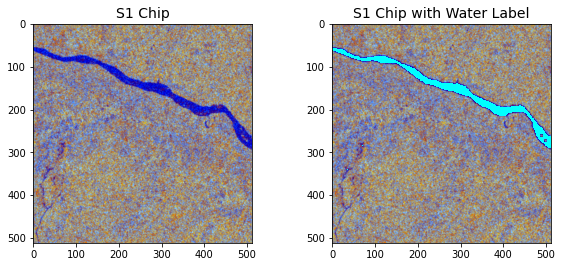

FLOOD ID:  ayt  Chip  ayt00


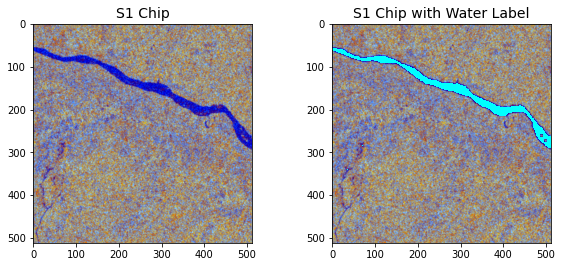

FLOOD ID:  ayt  Chip  ayt01


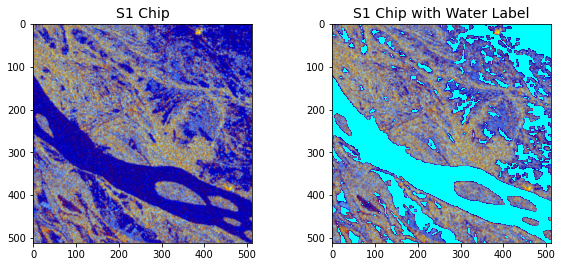

In [52]:
flood_id = metadata.flood_id.unique()[1]
chip_list = metadata[metadata.flood_id == flood_id].chip_id[:3]

for chip in chip_list:
    print('FLOOD ID: ',flood_id,' Chip ',chip)
    display_chip(chip,metadata)

In [53]:

def display_chip2(_id):

    f, ax = plt.subplots(2, 10, figsize=(100, 10))

    path = DATA_PATH + '/train_features/' + _id + '_vv' + EXT
    with rasterio.open(path) as img:
        vv = img.read(1)
        ax[0][0].imshow(vv, cmap="cool", alpha=1)
        ax[0][0].set_title("vv", fontsize=14)
    
    path = DATA_PATH + '/train_features/' + _id + '_vh' + EXT
    with rasterio.open(path) as img:
        vh = img.read(1)
        ax[0][1].imshow(vh, cmap="cool", alpha=1)
        ax[0][1].set_title("vh", fontsize=14)

    
    path = DATA_PATH + '/labels/' + _id + EXT
    with rasterio.open(path) as img:
        y = img.read(1)
        
    s1_img = np.stack((vv, vh), axis=-1)

    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]


    s1_img = scale_img(img)

    #ax[0][0].imshow(s1_img)
    #ax[0][0].set_title("S1 Chip", fontsize=14)

    label = np.ma.masked_where((y == 0) | (y == 255), y)

    for i in range(0, 10):
        ax[1][i].imshow(s1_img)
        ax[1][i].imshow(label, cmap="cool", alpha=1)
        ax[1][i].set_title("Water Label", fontsize=14)

    # ABS
    if True:
        va = np.abs(vv - vh)
        ax[0][2].imshow(s1_img)
        ax[0][2].imshow(va, cmap="cool", alpha=1)
        ax[0][2].set_title("abs", fontsize=14)

    # NASADEM
    if True:
        path = DATA_PATH + '/nasadem/' + _id + EXT
        with rasterio.open(path) as img:
            nasadem = img.read(1)
        ax[0][3].imshow(s1_img)
        ax[0][3].imshow(nasadem, cmap="cool", alpha=1)
        ax[0][3].set_title("nasadem", fontsize=14)

    # CHANGE
    p_channels = ['change', 'extent','seasonality','occurrence','recurrence','transitions']
    for i,c in enumerate(p_channels):
        if True:
            path = DATA_PATH + '/jrc_' + c + '/' + _id + EXT
            with rasterio.open(path) as img:
                c_jrc = img.read(1)
        ax[0][4 + i].imshow(s1_img)
        ax[0][4 + i].imshow(c_jrc, cmap="cool", alpha=1)
        ax[0][4 + i].set_title(c, fontsize=14)

    plt.show()
    plt.close()

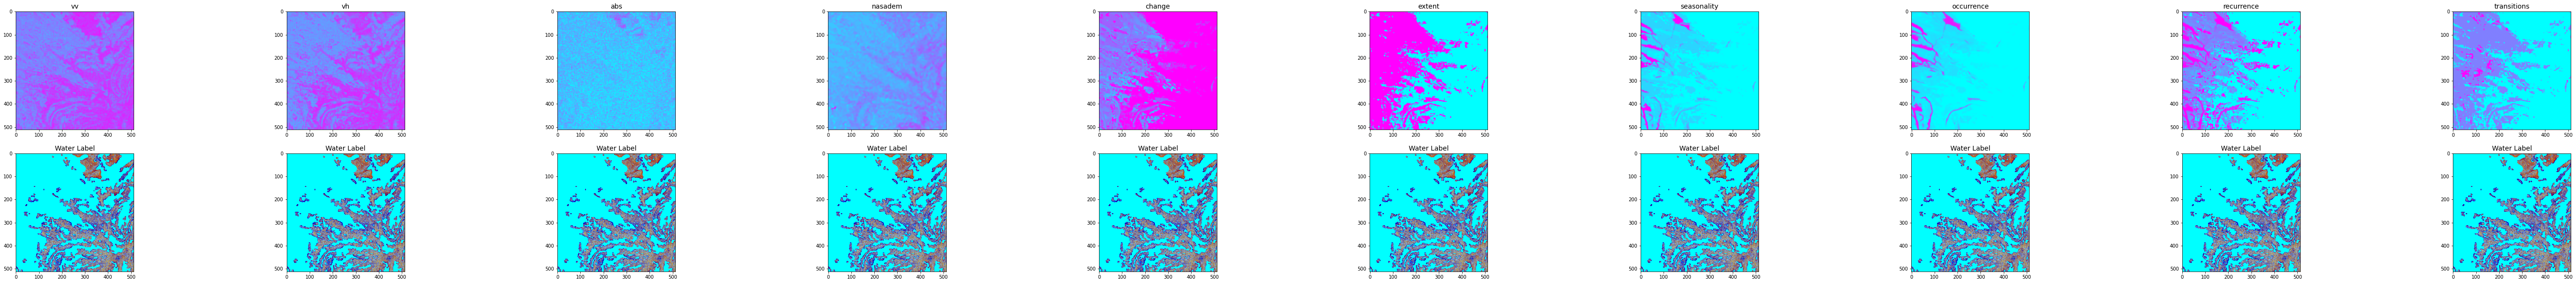

In [56]:
chip = metadata.chip_id[50]
display_chip2(chip)